## Conditional generation and imputation

En este notebook, se van a enseñar como usar las funcionalidades generación condicional e imputación

### Librerias

In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

In [13]:
%load_ext autoreload
%autoreload 2

import numpy as np

from functools import partial

import torch
from torch.utils.data import (
    DataLoader,
    Subset,
)
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.transforms import functional

from torchvision import transforms
from utils.data_loader import load_dataset

from utils import (
    plot_image_grid,
    load_dataset,
    plot_image_evolution_color,
    sample_initial_latents

)

from samplers import predictor_corrector_integrator, euler_maruyama_integrator
from diffusion import VEProcess

from score_models import ScoreNetConditional
from torch.optim import Adam
from tqdm.notebook import trange


n_threads = torch.get_num_threads()
print('Number of threads: {:d}'.format(n_threads))

device ='cuda'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Number of threads: 12


### Conditional generation

In [4]:
def colorize_grayscale(tensor_img):
    if tensor_img.shape[0] == 1:
        r, g, b = [torch.rand(1).item() for _ in range(3)]
        return torch.cat([tensor_img * r, tensor_img * g, tensor_img * b], dim=0)
    return tensor_img

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(colorize_grayscale),
])

data_train = load_dataset("mnist", transform=transform, return_loader=False)

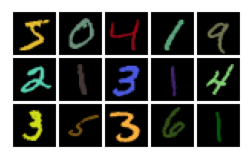

In [7]:
# Visualize training images
n_rows = 3
n_cols = 5

_ = plot_image_grid(
    images=[data_train[i][0] for i in range(n_rows * n_cols)],
    figsize =(3, 3),
    n_rows=n_rows,
    n_cols=n_cols,
)

In [11]:
sigma = 25.0
diffusion_process = VEProcess(
    sigma=sigma
)

In [ ]:
score_model = torch.nn.DataParallel(
    ScoreNetConditional(
    marginal_prob_std=diffusion_process.sigma_t,
    num_classes=10,  
    in_channels=3
))

score_model = score_model.to(device)

batch_size = 32

data_loader = DataLoader(
    data_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=n_threads,
)

learning_rate = 1.0e-3
optimizer = Adam(score_model.parameters(), lr=learning_rate)

n_epochs =  30
tqdm_epoch = trange(n_epochs)

for epoch in tqdm_epoch:
    avg_loss = 0.0
    num_items = 0
    for x, y in data_loader:
        x = x.to(device)
        y = y.to(device)
        loss = diffusion_process.loss_function_conditional(score_model, x, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]

    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))

    torch.save(score_model.state_dict(), 'check_point.pth')

  0%|          | 0/30 [00:00<?, ?it/s]

In [24]:
n_images = 5
target_class = torch.tensor([5] * n_images).to(device)  
score_function = lambda x_t, t: score_model(x_t, t, target_class)
drift_coefficient = lambda x_t, t: diffusion_process.reverse_drift(x_t, t, lambda x_t_, t_: score_model(x_t_, t_, target_class))

check_point = torch.load('check_point.pth', map_location=device)
score_model.load_state_dict(check_point)

diffusion_coefficient = diffusion_process.diffusion_coefficient

T = 1.0 - 1e-3
image_T = torch.randn(n_images, 3, 28, 28).to(device)


with torch.no_grad():
    times, synthetic_images_t = predictor_corrector_integrator(
        image_T,
        t_0=T,
        t_end=1.0e-3,
        n_steps=2000,
        drift_coefficient=drift_coefficient,
        diffusion_coefficient=diffusion_coefficient,
        score_function=score_function,
        n_corrector_steps=5,
        corrector_step_size=0.0001
    )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.512454..3.534674].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.400918..5.510325].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-19.624132..17.899595].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-16.169464..16.11497].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-14.528047..14.5982485].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-12.80349..13.607235].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-12.421575..14

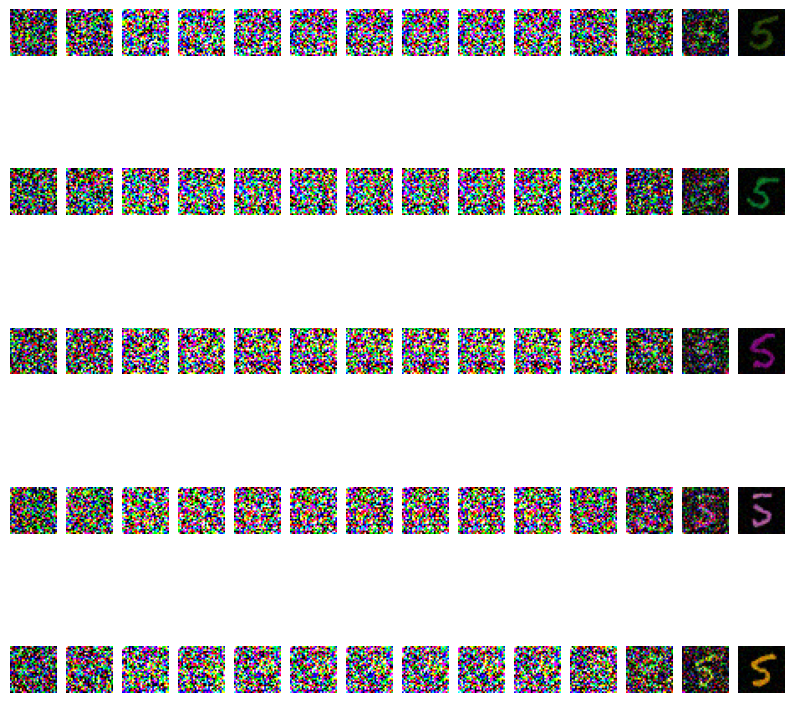

In [25]:
_ = plot_image_evolution_color(
    images=synthetic_images_t.cpu(),
    n_images=n_images,
    n_intermediate_steps=[0, 5, 200, 300, 400, 450, 470, 480, 490, 500, 1000,1500, 1800, 2000],
    figsize=(10, 10),
)

### Imputation

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(colorize_grayscale),
])

data= load_dataset("mnist", transform=transform, return_loader=False)

In [6]:
# Filtrar solo dígitos "3"
digit = 3
indices_digit = torch.where(torch.tensor(data.targets) == digit)[0]
digit_data = Subset(data, indices_digit)


/tmp/ipykernel_12336/1280510449.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  indices_digit = torch.where(torch.tensor(data.targets) == digit)[0]


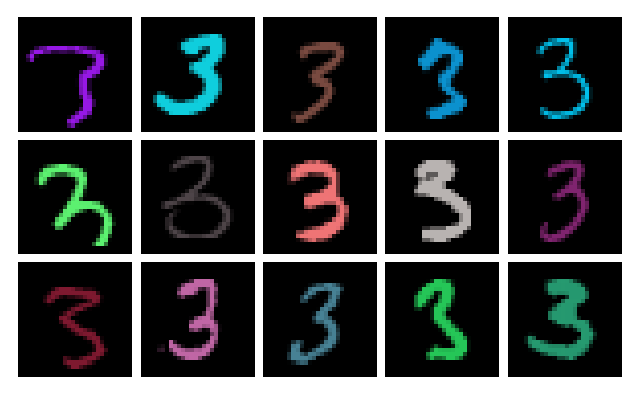

In [7]:
from torch.utils.data import random_split
train_size = int(0.8 * len(digit_data))
test_size = len(digit_data) - train_size
data_train, data_test = random_split(digit_data, [train_size, test_size])

n_rows = 3
n_cols = 5

_ = plot_image_grid(
    images=[data_train[i][0] for i in range(n_rows * n_cols)],
    figsize=(8, 5),
    n_rows=n_rows,
    n_cols=n_cols,
)


In [8]:
def mask_with_noise(image, mask_size=10):
    """Aplica una máscara cuadrada en el centro y sustituye por ruido."""
    C, H, W = image.shape
    masked = image.clone()
    mask = torch.ones_like(image)

    start_x = (W - mask_size) // 2
    end_x = start_x + mask_size
    start_y = (H - mask_size) // 2
    end_y = start_y + mask_size

    noise = torch.randn_like(masked[:, start_y:end_y, start_x:end_x])

    masked[:, start_y:end_y, start_x:end_x] = noise
    mask[:, start_y:end_y, start_x:end_x] = 0.0

    return masked, mask


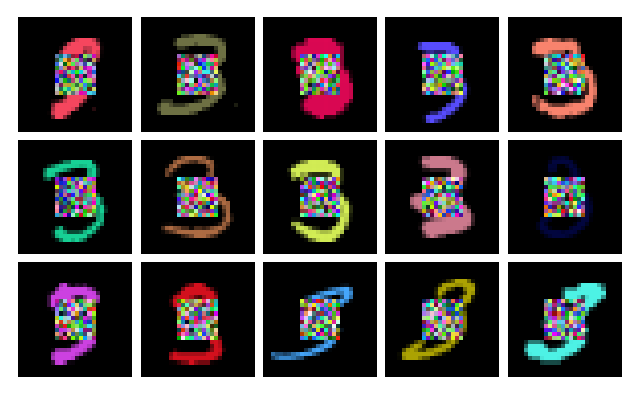

In [9]:
masked_images = []
for i in range(n_rows * n_cols):
    img, _ = data_test[i]
    masked, _ = mask_with_noise(img, mask_size=10)
    masked_images.append(masked)

_ = plot_image_grid(
    images=masked_images,
    figsize=(8, 5),
    n_rows=n_rows,
    n_cols=n_cols,
)


In [14]:
from score_models import ScoreNet
score_model = torch.nn.DataParallel(
    ScoreNet(
    marginal_prob_std=diffusion_process.sigma_t,
    in_channels=3
))

score_model = score_model.to(device)

batch_size = 32

data_loader = DataLoader(
    data_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=n_threads,
)

learning_rate = 1.0e-3
optimizer = Adam(score_model.parameters(), lr=learning_rate)

n_epochs =  30
tqdm_epoch = trange(n_epochs)

for epoch in tqdm_epoch:
    avg_loss = 0.0
    num_items = 0
    for x, y in data_loader:
        x = x.to(device)
        y = y.to(device)
        loss = diffusion_process.loss_function(score_model, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]

    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))

    torch.save(score_model.state_dict(), 'check_point.pth')

  0%|          | 0/30 [00:00<?, ?it/s]

In [15]:
n_images = 5
T = 1.0 - 1e-3
T_tensor = torch.tensor([T], device=device)
diffusion_coefficient = diffusion_process.diffusion_coefficient

x_0_batch = torch.stack([data_test[i][0] for i in range(n_images)]).to(device)  

masked_batch = []
mask_batch = []

for i in range(n_images):
    masked_img, mask = mask_with_noise(x_0_batch[i])
    masked_batch.append(masked_img)
    mask_batch.append(mask)

masked_batch = torch.stack(masked_batch).to(device)  
mask_batch = torch.stack(mask_batch).to(device)      

# Inicializar con ruido en las regiones faltantes
x_T = torch.randn_like(x_0_batch)
image_T = x_T * (1 - mask_batch) + x_0_batch * mask_batch 

# Sampling con la máscara
with torch.no_grad():
    times, synthetic_images_t = euler_maruyama_integrator(
        x_0=image_T,
        t_0=T,
        t_end=1e-3,
        n_steps=2000,
        drift_coefficient=lambda x_t, t: diffusion_process.reverse_drift(x_t, t, score_model),
        diffusion_coefficient=diffusion_coefficient,
        mask=mask_batch,  
    )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.1732557..2.6839714].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.4440074..4.50329].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-15.508808..14.717116].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-11.990521..10.315572].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-12.616744..10.990251].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-13.573157..9.639265].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-12.431103..

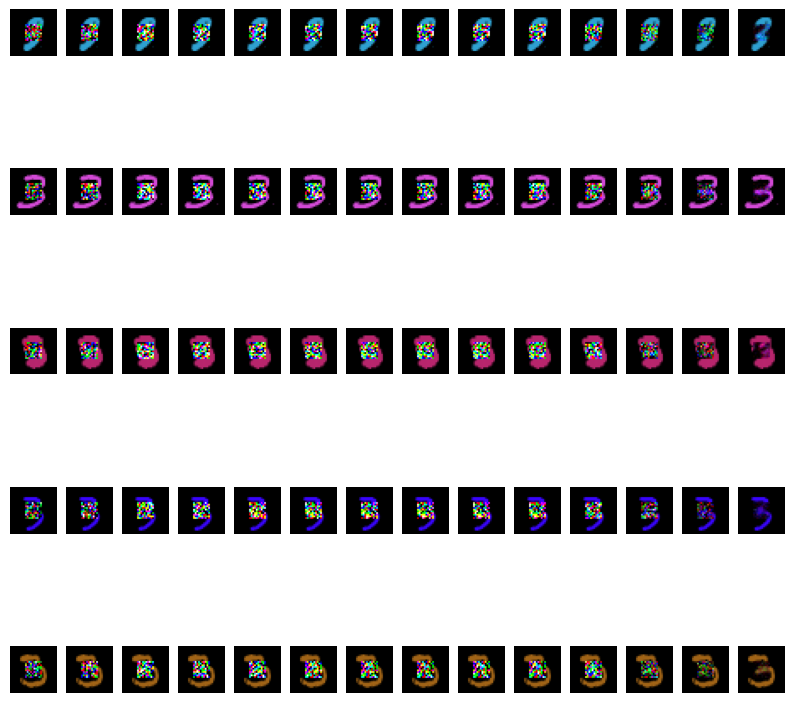

In [16]:
_ = plot_image_evolution_color(
    images=synthetic_images_t.cpu(),
    n_images=n_images,
    n_intermediate_steps=[0, 5, 200, 300, 400, 450, 470, 480, 490, 500, 1000,1500, 1800, 2000],
    figsize=(10, 10),
)